# Paleo-Detector Analysis Pipeline

This notebook provides a complete, end-to-end workflow for the phenomenological analysis of paleo-detectors. It is designed to calculate the expected nuclear recoil track spectra from both external cosmic ray muon signals and various internal/atmospheric backgrounds.

The pipeline is built around the *mineral_utils.py* module, which contains the *Paleodetector* class. This class acts as the physics engine, handling all low-level data processing and calculations. The notebook serves as a high-level interface to configure and orchestrate the analysis.

### Workflow Overview:

**1. Configuration:** All analysis parameters are defined in the configuration cells. This includes selecting the mineral from a library, defining the geological history of the sample (age, exposure time, deposition rate), and setting up the astrophysical scenarios for the cosmic ray flux.

**2. Initialization:** A Paleodetector object is created. This object automatically loads and caches all necessary input data, such as SRIM tables for ion ranges and pre-computed Geant4 results for muon interactions.

**3. Background Calculation:** The notebook calculates the track spectra for the primary background sources:

- Spontaneous Fission: Tracks from the spontaneous fission of Uranium-238 impurities within the mineral.

- Radiogenic Neutrons: Tracks from neutrons produced by (α,n) reactions in the surrounding rock.

- Neutrinos: Tracks from coherent elastic neutrino-nucleus scattering.

**7. Signal Calculation:** For each defined astrophysical scenario, the notebook calculates the track spectrum from cosmic ray muons. This core step includes a sophisticated model for a time-variant cosmic ray flux and the continuous deposition of overburden, which attenuates the signal over the exposure window. The time integration is performed in parallel for efficiency.

**8. Analysis & Plotting:** The final signal and background components are combined to produce the summary plots, showing the total expected number of tracks as a function of track length.


In [1]:
import yaml
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

# --- Custom Utility Module ---
from mineral_utils import Paleodetector, slice_spectrum, detection_model_efficiency

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
CONFIG = yaml.safe_load(open('Data/basic_config.yaml', 'r'))
MINERAL_LIBRARY = yaml.safe_load(open('Data/mineral_library.yaml', 'r'))

In [3]:
mineral_name =  "Quartz"  # Must match a key in MINERAL_LIBRARY

sample_mass_kg = 0.0000005       # Sample mass in kg (e.g., 0.01 for 10g)
total_exposure_kyr = 300.       # Total age of the sample in kyr
exposure_window_kyr = 300.      # Duration of CR signal exposure in kyr

event_overburden_density_g_cm3 = 2.6
event_overburden_depth = 30.

x_bins = np.linspace(0, 50000, 201)        #Track length bins in nm
x_mids = x_bins[:-1] + np.diff(x_bins) / 2

energies = np.array(CONFIG["geant4_energy_bins_gev"])[:90]  # Energy bins in GeV

In [4]:
scenario_config_simple = {
    'name': 'simple',
    'event_fluxes': {
        0.: ('H3a', 'H3a'),
        300.: ('H3a', 'H3a'),
    }
}

In [5]:
# --- Setup & Verification ---
mineral_config = MINERAL_LIBRARY.get(mineral_name)
if not mineral_config:
    raise ValueError(f"Mineral '{mineral_name}' not found in MINERAL_LIBRARY.")

mineral = Paleodetector(mineral_config)

Initialized Paleodetector: Quartz


In [6]:
fission_rate = mineral.calculate_fission_spectrum(x_bins)

cumulative_counts = np.concatenate(([0], np.cumsum(fission_rate * 1e-3 * 1e-3 * np.diff(x_bins))))

cdf_interp = interp1d(x_bins, cumulative_counts, kind='linear', bounds_error=False, fill_value=(0, cumulative_counts[-1]))

tracks_fission = cdf_interp(x_bins[1:]) - cdf_interp(x_bins[:-1])

Calculating spontaneous fission background...


In [7]:
mineral._interpolate_flux_scenarios(scenario_config_simple, species='mu-')
mineral._interpolate_flux_scenarios(scenario_config_simple, species='mu+')
mineral._interpolate_flux_scenarios(scenario_config_simple, species='neutron')

mineral._load_depth_interpolators(species='mu-')
mineral._load_depth_interpolators(species='mu+')
mineral._load_depth_interpolators(species='neutron')

In [8]:
drdx_mum = mineral.calculate_particle_signal_spectrum(x_bins=x_bins, t_kyr=0.0, scenario_name='simple', energy_bins_gev=energies, depth_mwe=0.2*event_overburden_density_g_cm3, species='mu-')

drdx_mup = mineral.calculate_particle_signal_spectrum(x_bins=x_bins, t_kyr=0.0, scenario_name='simple', energy_bins_gev=energies, depth_mwe=0.2*event_overburden_density_g_cm3, species='mu+')

drdx_up = drdx_mum + drdx_mup

cumulative_counts = np.concatenate(([0], np.cumsum(drdx_up * 1e-3 * 1e-3 * np.diff(x_bins))))

cdf_interp = interp1d(x_bins, cumulative_counts, kind='linear', bounds_error=False, fill_value=(0, cumulative_counts[-1]))

tracks_up = cdf_interp(x_bins[1:]) - cdf_interp(x_bins[:-1])

    - Saved processed data to Data/processed_recoils/Quartz/mu-/simple_0.0kyr_0.5mwe.npz
    - Saved processed data to Data/processed_recoils/Quartz/mu+/simple_0.0kyr_0.5mwe.npz


In [9]:
drdx_mum = mineral.calculate_particle_signal_spectrum(x_bins=x_bins, t_kyr=0.0, scenario_name='simple', energy_bins_gev=energies, depth_mwe=event_overburden_depth*event_overburden_density_g_cm3, species='mu-')

drdx_mup = mineral.calculate_particle_signal_spectrum(x_bins=x_bins, t_kyr=0.0, scenario_name='simple', energy_bins_gev=energies, depth_mwe=event_overburden_depth*event_overburden_density_g_cm3, species='mu+')

drdx_down = drdx_mum + drdx_mup

cumulative_counts = np.concatenate(([0], np.cumsum(drdx_down * 1e-3 * 1e-3 * np.diff(x_bins))))

cdf_interp = interp1d(x_bins, cumulative_counts, kind='linear', bounds_error=False, fill_value=(0, cumulative_counts[-1]))

tracks_down = cdf_interp(x_bins[1:]) - cdf_interp(x_bins[:-1])

    - Saved processed data to Data/processed_recoils/Quartz/mu-/simple_0.0kyr_78.0mwe.npz
    - Saved processed data to Data/processed_recoils/Quartz/mu+/simple_0.0kyr_78.0mwe.npz


In [10]:
drdx_neut = mineral.calculate_particle_signal_spectrum(x_bins=x_bins, t_kyr=0.0, scenario_name='simple', energy_bins_gev=energies, depth_mwe=0.2*event_overburden_density_g_cm3, species='neutron')

cumulative_counts = np.concatenate(([0], np.cumsum(drdx_neut * 1e-3 * 1e-3 * np.diff(x_bins))))

cdf_interp = interp1d(x_bins, cumulative_counts, kind='linear', bounds_error=False, fill_value=(0, cumulative_counts[-1]))

neutron_tracks_up = cdf_interp(x_bins[1:]) - cdf_interp(x_bins[:-1])

    - Saved processed data to Data/processed_recoils/Quartz/neutron/simple_0.0kyr_0.5mwe.npz


In [11]:
drdx_neut = mineral.calculate_particle_signal_spectrum(x_bins=x_bins, t_kyr=0.0, scenario_name='simple', energy_bins_gev=energies, depth_mwe=event_overburden_depth*event_overburden_density_g_cm3, species='neutron')

cumulative_counts = np.concatenate(([0], np.cumsum(drdx_neut * 1e-3 * 1e-3 * np.diff(x_bins))))

cdf_interp = interp1d(x_bins, cumulative_counts, kind='linear', bounds_error=False, fill_value=(0, cumulative_counts[-1]))

neutron_tracks_down = cdf_interp(x_bins[1:]) - cdf_interp(x_bins[:-1])

    - Saved processed data to Data/processed_recoils/Quartz/neutron/simple_0.0kyr_78.0mwe.npz


In [12]:
drdx_s_neut = mineral.calculate_particle_signal_spectrum(x_bins=x_bins, t_kyr=0.0, scenario_name='simple', energy_bins_gev=energies, depth_mwe=0.2*event_overburden_density_g_cm3, species='secondary_neutron')

cumulative_counts = np.concatenate(([0], np.cumsum(drdx_s_neut * 1e-3 * 1e-3 * np.diff(x_bins))))

cdf_interp = interp1d(x_bins, cumulative_counts, kind='linear', bounds_error=False, fill_value=(0, cumulative_counts[-1]))

neutron_s_tracks_up = cdf_interp(x_bins[1:]) - cdf_interp(x_bins[:-1])

    - Saved processed data to Data/processed_recoils/Quartz/secondary_neutron/simple_0.0kyr_0.5mwe.npz


In [13]:
drdx_s_neut = mineral.calculate_particle_signal_spectrum(x_bins=x_bins, t_kyr=0.0, scenario_name='simple', energy_bins_gev=energies, depth_mwe=event_overburden_depth*event_overburden_density_g_cm3, species='secondary_neutron')

cumulative_counts = np.concatenate(([0], np.cumsum(drdx_s_neut * 1e-3 * 1e-3 * np.diff(x_bins))))

cdf_interp = interp1d(x_bins, cumulative_counts, kind='linear', bounds_error=False, fill_value=(0, cumulative_counts[-1]))

neutron_s_tracks_down = cdf_interp(x_bins[1:]) - cdf_interp(x_bins[:-1])

    - Saved processed data to Data/processed_recoils/Quartz/secondary_neutron/simple_0.0kyr_78.0mwe.npz


In [14]:
drdx_radiogenic = mineral.calculate_background_neutron_spectrum(x_bins=x_bins, energy_bins_gev=energies)

cumulative_counts = np.concatenate(([0], np.cumsum(drdx_radiogenic * 1e-3 * 1e-3 * np.diff(x_bins))))

cdf_interp = interp1d(x_bins, cumulative_counts, kind='linear', bounds_error=False, fill_value=(0, cumulative_counts[-1]))

radiogenic_n_tracks = cdf_interp(x_bins[1:]) - cdf_interp(x_bins[:-1])

    - Saved processed data to Data/processed_recoils/Quartz/fission_n.npz
    - Saved processed data to Data/processed_recoils/Quartz/alpha_n.npz


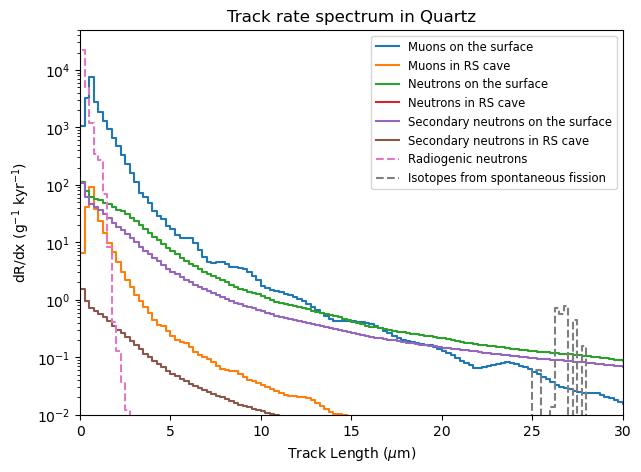

In [15]:
fig, ax = plt.subplots(figsize=[7, 5])

ax.step(x_mids/1000., tracks_up, label='Muons on the surface', where='mid')

ax.step(x_mids/1000., tracks_down, label='Muons in RS cave', where='mid')
ax.step(x_mids/1000., neutron_tracks_up, label='Neutrons on the surface', where='mid')
ax.step(x_mids/1000., neutron_tracks_down, label='Neutrons in RS cave', where='mid')

ax.step(x_mids/1000., neutron_s_tracks_up, label='Secondary neutrons on the surface', where='mid')
ax.step(x_mids/1000., neutron_s_tracks_down, label='Secondary neutrons in RS cave', where='mid')

ax.step(x_mids/1000., radiogenic_n_tracks, label='Radiogenic neutrons', where='mid', linestyle='--')

ax.step(x_mids/1000., tracks_fission, where='mid', label='Isotopes from spontaneous fission', linestyle='--')

ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel(r"Track Length ($\mu$m)")
ax.set_ylabel(r"dR/dx (g$^{-1}$ kyr$^{-1}$)")
ax.set_title(f"Track rate spectrum in {mineral_name}")
ax.set_ylim(1e-2, 5e4)
ax.set_xlim(0., 30.)
ax.legend(fontsize='small', loc='upper right')
plt.savefig("Plots/RSC_drdx.png", dpi=500)
plt.show()

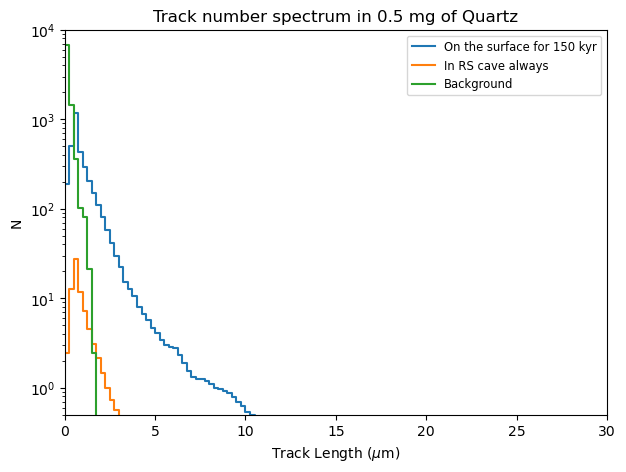

In [16]:
fig, ax = plt.subplots(figsize=[7, 5])

ax.step(x_mids/1000., (tracks_up+neutron_tracks_up+neutron_s_tracks_up)*1e-3*1.5e2 + (tracks_down+neutron_s_tracks_down)*1e-3*1.5e2, label='On the surface for 150 kyr', where='mid')
ax.step(x_mids/1000., (tracks_down+neutron_s_tracks_down)*1e-3*3e2, label='In RS cave always', where='mid')

ax.step(x_mids/1000., (radiogenic_n_tracks+tracks_fission)*1e-3*3e2, label='Background', where='mid')

ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel(r"Track Length ($\mu$m)")
ax.set_ylabel(r"N")
ax.set_title(f"Track number spectrum in 0.5 mg of {mineral_name}")
ax.set_ylim(0.5, 1e4)
ax.set_xlim(0., 30.)
ax.legend(fontsize='small', loc='upper right')
plt.savefig("Plots/RSC_example.png", dpi=500)
plt.show()

In [22]:
sliced_up = slice_spectrum(x_bins, (tracks_up+neutron_tracks_up+neutron_s_tracks_up)*1e-3*1.5e2 + (tracks_down+neutron_s_tracks_down)*1e-3*1.5e2, pit_width=1500.)
sliced_down = slice_spectrum(x_bins, (tracks_up+neutron_tracks_up+neutron_s_tracks_up)*1e-3*0e2 + (tracks_down+neutron_s_tracks_down)*1e-3*3e2, pit_width=1500.)

sliced_bkg = slice_spectrum(x_bins, tracks_fission*1e-3*3e2 + radiogenic_n_tracks*1e-3*3e2, pit_width=1500.)

In [23]:
counts_with_efficiency_up = detection_model_efficiency(x_bins, sliced_up, 0.66, 0.88, 2500., 500., 1500., meas_error=500.)
counts_with_efficiency_down = detection_model_efficiency(x_bins, sliced_down, 0.66, 0.88, 2500., 500., 1500., meas_error=500.)
counts_with_efficiency_bkg = detection_model_efficiency(x_bins, sliced_bkg, 0.66, 0.88, 2500., 500., 1500., meas_error=500.)

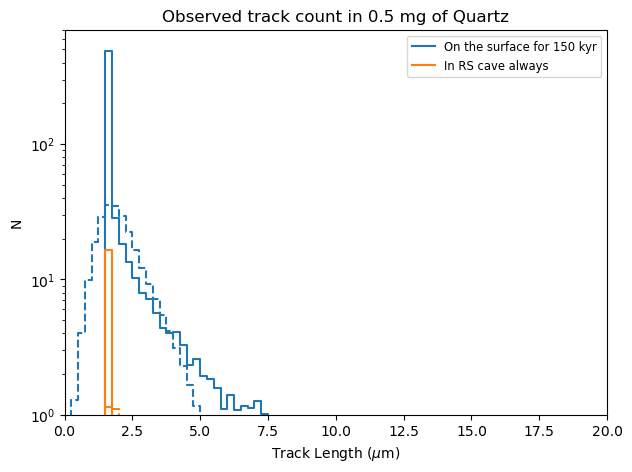

In [24]:
fig, ax = plt.subplots(figsize=[7, 5])

ax.step(x_mids/1000., counts_with_efficiency_up + counts_with_efficiency_bkg, color = 'C0', linestyle = '--', where='mid')
ax.step(x_mids/1000., counts_with_efficiency_down + counts_with_efficiency_bkg, color = 'C1', linestyle = '--', where='mid')

ax.step(x_mids/1000., sliced_up + sliced_bkg, color = 'C0', linestyle = '-', label='On the surface for 150 kyr', where='mid')
ax.step(x_mids/1000., sliced_down + sliced_bkg, color = 'C1', linestyle = '-', label='In RS cave always', where='mid')

ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel(r"Track Length ($\mu$m)")
ax.set_ylabel(r"N")
ax.set_title(f"Observed track count in 0.5 mg of {mineral_name}")
ax.set_ylim(1, 7e2)
ax.set_xlim(0., 20.)
ax.legend(fontsize='small', loc='upper right')
plt.savefig("Plots/RSC_obs.png", dpi=500)
plt.show()

In [25]:
print(f'Expected counts with efficiency: {np.sum(counts_with_efficiency_down + counts_with_efficiency_bkg)} in the "down" scenario, {np.sum(counts_with_efficiency_up + counts_with_efficiency_bkg)} in the "up" scenario.')

Expected counts with efficiency: 7.79296717392747 in the "down" scenario, 250.90929606370946 in the "up" scenario.
